# 3D CV laboratory assignment

In many computer vision problems, a real-world object $B$ is represented by its 3d-model in the form of a ***point cloud***, i.e., a set $\mathcal{P} =\{\mathbf{x}_j\}_{j=1}^N \subset \mathbb{R}^3$ of points $\mathbf{x}_j$ on the boundary $\partial B$ of $B$. One of the most important tasks in 3D CV is to determine the local geometry of $B$ around a point $\mathbf{y}_0\subset \partial B$ from the point cloud $\mathcal{P}$, which includes finding 

*   the ***normal*** to the boundary $\partial B$ at $\mathbf{y}_0$
*   the ***principal directions*** at $\mathbf{y}_0$, along which the surface shows the extreme behavior
*   the ***principal curvatures*** that characterize "flatness" of $\partial B$ in the principal directions 

Ability to estimate these features is crucial in constructing accurate surface models (e.g. differentiable meshes).

The aim of this lab assignment is to formulate the tasks of determining these fetures as optimization problems and suggest simple efficient ways to solve them. 

For testing purposes, we'll be working with model convex body $B$ that is the ellipsoid
$$
	E: \quad \frac{x^2}{a^2} + \frac{y^2}{b^2} + \frac{z^2}{c^2} \le 1,
$$
since all the quantities of interest are explicitly available in that case. Observe that the boundary $E:=\partial B$ can be written in spherical coordinates as 
$
	\quad x = a \cos \phi \sin\psi , \quad y = b \sin \phi \sin \psi, \quad z = c \cos \psi,\quad
$
with $\phi \in [0,2\pi)$ and $\psi \in [0,\pi]$. By generating randomly the spherical angles $\phi$ and $\psi$, we'll generate a good point cloud of $E$.



## Instructions 

1.   Form a team of two; copy the notebook to your Google Drive, rename it
2.   Fill in the $\dots$ blanks in the code and comment sections
3.   Do not delete any cells or comments; do not move the cells around
4.   Submit your notebook to **cms** along with the pdf output. Do not forget to run all cells before submission. Also, do not make *looong* prints


## 1. Preparation and Data Generation **(1 pt)**

### 1.1 First we need to import packages


In [3]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### 1.2 Let's fix configuration parameters

In [4]:
#  fix parameters of the ellipse
a = 5.0
b = 3.0
c = 3.0

### 1.3 Now we set up functions for surface points and normal to the boundary

In [5]:
#  generate a point on the ellipsoid 
def surface_point(sph_angles):
  """
  sph_angles is an array of two spherical angles: 0 \le \phi \le 2 \pi, 0 \le \psi \le \pi
  """
  phi = sph_angles[0]
  psi = sph_angles[1]
  return np.array([a * np.cos(phi) * np.sin(psi), b * np.sin(phi) * np.sin(psi), c* np.cos(psi)])

In [6]:
def normalize(vec):
  """
  Helper function to normalize a vector vec (np.array)
  """
  return vec / np.sqrt(np.dot(vec,vec))

In [7]:
def normal(sph_angles):
  """
  returns a normalized normal 
  """
  x, y, z = surface_point(sph_angles)
  nvec = np.array([x / a**2,  y / b**2, z / c**2])
  return normalize(nvec)

### 1.4 Surface patch

Generate a surface patch around a point $\mathbf{y}_0 \in \partial B$

In [8]:
def randrange(n, vmin, vmax):
    """
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    """
    return (vmax - vmin)*np.random.rand(n) + vmin

In [9]:
#  generate a patch around a point
def surface_patch(phi, psi, no_pts = 1000, size = 0.1):
  phis = randrange(no_pts, - size, size) + phi
  psis = randrange(no_pts, - size, size) + psi
  
  angles = np.transpose([phis, psis])
  
  X = np.array([surface_point(angles[i]) for i in range(len(angles))])

  return X

### ***Question:***

*   Explain the role of the hyperparameters `no_pts` and `size`

-----
- `no_pts` - number of points for surface patch  we're generating
- `size` - angles for ellipsoid are generated uniformly randomly in the range (-size + c, size + c), so that is basically 1/2 of size of range, where we generate angles.



### 1.5 Visualization

This is the function to visualize the patch 


In [10]:
def patch_plot(X):
  """
  X is the np.array of shape (n, 3) of surface points
  """
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  # Set axes limit
  #plt.xlim(-a,a)
  #plt.ylim(-b,b)
  
  ax.scatter(X[:,0], X[:,1], X[:,2])

  ax.set_xlabel('X Label')
  ax.set_ylabel('Y Label')
  ax.set_zlabel('Z Label')

  plt.show()

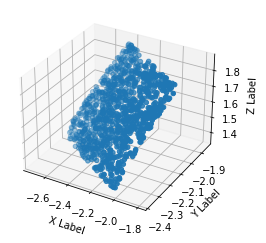

In [11]:
patch_plot(surface_patch(1, -1, 1000, 0.1))

---  
---  
## 2. Normal to the plane (**14 pts**)

Our first step is to estimate the ***normal*** to the boundary $\partial B$ of $B$. 

The problem seems trivial but in fact its efficient solution is crucial for almost all next steps in geometrically-based analysis. In this part of the assignment, you are asked to implement several different approaches, compare their efficiency and then suggest some improvements. 

### 2.1. A naive approach (**4 pts**)

Recall that, for a convex body $B$ with boundary $\partial B$, $\mathbf{y}_0 \in \partial B$, and $\mathbf{n}$ a normal to $\partial B$ at $\mathbf{y}_0$, we have
$$
		\mathbf{n} \cdot (\mathbf{x}-\mathbf{y}_0) \le 0
$$
for every $\mathbf{x} \in B$. Therefore, a natural minimization task to determine $\mathbf{n}$ is 
$$
		\mbox{argmin}_{\mathbf{n}} \sum_{k=1}^m \mathbf{n} \cdot (\mathbf{y}_k - \mathbf{y}_0), \qquad \|\mathbf{n}\| = 1.
$$
Solution of this problem can be obtained in the closed form, without any extra tools. 

### 2.1.1. ***Question (2 pts)***


*   Derive the closed form solution of the above minimization problem by setting the gradient to zero

...



$S=\sum_{k=1}^m n\cdot(y_k-y_0)= n_1 \sum_{k=1}^m (y_{k1}-y_{01}) + n_2 \sum_{k=1}^m (y_{k2}-y_{02}) + n_3 \sum_{k=1}^m (y_{k3}-y_{03})=n_1 A + n_2 B + n_3 C$, where $n_1$, $n_2$, $n_3$ - components of $n$


Since we have condition $||n|| = 1; n_1^2+n_2^2+n_3^2=1$, we get the following Lagrangian:


$$L= n_1 A + n_2 B + n_3 B - (n_1^2+n_2^2+n_3^2 - 1) \lambda$$


$$L' = 0;\;\; L_{n_1}'=A+2n_1\lambda=0;\;\;  L_{n_2}'=B+2n_2\lambda=0;\;\;  L_{n_3}'=A+2n_3\lambda=0;\;\; L_{\lambda}=n_1^2+n_2^2+n_3^2-1=0 $$
$$L_{\lambda}' = \frac{A^2+B^2+C^2}{4\lambda^2}-1=0 \rightarrow \lambda=\pm\frac{\sqrt{A^2+B^2+C^2}}{2} \rightarrow n=\mp(\frac{A}{{\sqrt{A^2+B^2+C^2}}};\frac{B}{{\sqrt{A^2+B^2+C^2}}};\frac{C}{{\sqrt{A^2+B^2+C^2}}})$$

Now since we want to minimize loss function, and we have two critical function, we must verify second derivative.

Since $S_{n_i}' = A/B/C + 2 n_i \lambda$, $S_{n_i}'' = 2 \lambda$, since we want minimum, second derivative should be > 0, so we take
$$\lambda=\frac{\sqrt{A^2+B^2+C^2}}{2}$$
and
$$n=(\frac{-A}{{\sqrt{A^2+B^2+C^2}}};\frac{-B}{{\sqrt{A^2+B^2+C^2}}};\frac{-C}{{\sqrt{A^2+B^2+C^2}}})$$


The result is quite intuitive, since this is just normalized $-centroid + y_0$

...


### 2.1.2. Code (**1 pt**)

In [12]:
def normal_estimate_lin(X, y):
  """
  implementation of the naive approach
  """
  return -normalize(np.sum(X-y, axis=0))

### 2.1.3. Test the approach on random points

In [13]:
phi, psi = np.pi * np.random.sample(2)

y = surface_point([phi, psi])
X = surface_patch(phi, psi, no_pts = 1000_00, size = 3)   # original params: no_pts=1000, size=3

print("Estimated normal", normal_estimate_lin(X,y))
print("Actual normal", normal([phi, psi]))

Estimated normal [0.16667197 0.48634412 0.85772365]
Actual normal [0.05665348 0.47692136 0.87711824]


### ***Question (1 pt)***

* Try tuning hyper-parameters to optimize performance
    Generaly the bigger number of points `no_pts` and the bigger size of range from where we sample points `size`, the better estimation. The reason is very obvious - more points better estimate surface that is actually smooth. Also bigger `size` assures that we get big enough neighborhood.
* Think why the naive approach does not return a good result
    a) points far from $y_0$ shouldn't influence normal at this point much.
    b) Since we sample points at random, they are not evenly distributed in space, result is highly biased, since we directly from points estimate normal.


## 2.2. Weighting the points (**4 pts**)

Points that are far from the point $\mathbf{y}_0$ bear less information about geometry around $\mathbf{y}_0$ and therefore should contribute less in determining $\mathbf{n}$. We'll use exponentially decaying weights $w_j = \exp(-c\|\mathbf{y_j}- \mathbf{y}_0\|^2)$ to improve the naive approach 

### 2.2.1. Setting the weights

In [14]:
def sqdist(x, y):
  return np.dot(x - y, x - y)

def weights(X, y, c):
  weights = np.sum(np.multiply(X-y, X-y), axis = 1)
  return  np.exp(- c * weights)    

### 2.2.2. Weighted naive approach (**2 pts**)

Rederive the solution of the optimization task to determine $\mathbf{n}$ 
$$
		\mbox{argmin}_{\mathbf{n}} \sum_{k=1}^m w_j \ \mathbf{n} \cdot (\mathbf{y}_k - \mathbf{y}_0), \qquad \|\mathbf{n}\| = 1.
$$


Since weights are just constant number that are calculated before everyhing, they don't influence derivative. We just have to redefine $A$, $B$, $C$

$A=\sum_{k=1}^m (y_{k1}-y_{01}) \rightarrow A'=\sum_{k=1}^m w_k (y_{k1}-y_{01})$,
$B=\sum_{k=1}^m (y_{k2}-y_{02}) \rightarrow B'=\sum_{k=1}^m w_k (y_{k2}-y_{02})$,
$C=\sum_{k=1}^m (y_{k3}-y_{03}) \rightarrow C'=\sum_{k=1}^m w_k (y_{k3}-y_{03})$,

$$n=(\frac{-A'}{{\sqrt{A'^2+B'^2+C'^2}}};\frac{-B'}{{\sqrt{A'^2+B'^2+C'^2}}};\frac{-C'}{{\sqrt{A'^2+B'^2+C'^2}}})$$


### 2.2.3. Code and testing (**1 pt**)

In [15]:
def normal_estimate_weight(X, y, c):
  wghts = weights(X, y, c)
  # print(min(wghts))                   #min
  # print(max(wghts))                   #max
  # print(np.mean(wghts))               #average
  # print(sorted(wghts)[len(wghts)//2]) # mode
  return -normalize(np.sum((X-y)*wghts.reshape((-1, 1)), axis=0))

In [16]:
# phi, psi = 1, 1
phi, psi = np.pi * np.random.sample(2)


y = surface_point([phi, psi])
X = surface_patch(phi, psi, no_pts = 1000_00, size = 3)

print("Estimated normal", normal_estimate_weight(X, y, 0.008))
print("Actual normal", normal([phi, psi]))

Estimated normal [0.78642481 0.43383922 0.43968119]
Actual normal [0.42183189 0.60890755 0.6717808 ]


### 2.2.4. Conclusions (**1 pt**)

...

Looks like weighting didn't change much, estimation is still very bad, and unstable (highly depends on generated points).
I didn't manage to find parameters that would outperform previous approach

...

## 2.3. Tangent plane (**4 pts**)

The tangent plane $\pi$ at the point $\mathbf{y}_0$ gives a very good approximation to the surface $\partial B$ in a neighbourhood of $\mathbf{y}_0$, and thus the distances to $\pi$ from the neighbouring points should be small. In the second approach, we find the tangent plane $\pi_0$ (and thus its normal vector $\mathbf{n}$) as a plane minimizing the (weighted) sum of distances to the points $\mathbf{y}_k$:
$$
		\pi_0 :=	\mbox{argmin}_{\pi} \sum_{k=1}^{m} w_k \mbox{dist}(\mathbf{y}_k, \pi)
$$
The difference with the previous approach is that we are summing the absolute values $|\mathbf{n} \cdot (\mathbf{y}_k-\mathbf{y}_0)|$ of the scalar products. 


### 2.3.1. Gradient

***Task (2 pts)*** 

*   Calculate the gradient of the objective function $f(\mathbf{n}) = \sum_{k=1}^{m} w_k |\mathbf{n} \cdot (\mathbf{y}_k-\mathbf{y}_0)|$

...

$$S'=(\sum_{k=1}^m w_k |n (y_k-y_0)|)' = \sum_{k=1}^m w_k  |n (y_k-y_0)|' = \sum_{k=1}^m w_k \cdot sign(n (y_k-y_0)) \cdot (y_k-y_0)$$


So basically, we just have to multiply weights by sign of $n (y_k-y_0)$ and than return weighted $\sum_{k=1}^m (y_k-y_0)$.
...




### 2.3.2. Code (**2 pts**)

In [17]:
def grad(X, y, nvec, c = 100):
  wghts = weights(X, y, c)
  # positive = np.where(np.dot(X, nvec) > np.dot(y, nvec))[0]
  signs = np.sign(np.dot(X-y, nvec))
  new_weights = wghts * signs
  return np.sum((X-y)*new_weights.reshape((-1, 1)), axis=0)

In [18]:
def objective(X, y, nvec):
  return np.dot(nvec, grad(X, y, nvec))


### 2.3.3. We'll use the gradient descent approach to determine the solution

In [20]:
### gradient descent estimate

def grad_desc_tangent(X, y):
  alpha = 0.01  # learning rate
  steps = 0
  nvec = normal_estimate_lin(X,y)
  g_cur = objective(X, y, nvec)

  while alpha > 0.0001 and steps < 10000:
    steps +=1
    nvec = nvec - np.multiply(grad(X, y, nvec), alpha)
    nvec = normalize(nvec)
    
    if objective(X, y, nvec) > g_cur:
      alpha = alpha/2
    else:   
      g_cur = objective(X, y, nvec)

  # print(steps)
  return nvec

### 2.3.4. Test the implementation

In [21]:
phi, psi = np.pi * np.random.sample(2)

y = surface_point([phi, psi])
X = surface_patch(phi, psi, no_pts = 1000, size = 0.01)

nvec = grad_desc_tangent(X, y)

print("Result of the gradient descent: ", nvec)
print("Actual normal: ", normal([phi, psi]))

Result of the gradient descent:  [-0.00291891  0.04940135  0.99877474]
Actual normal:  [-0.00277699  0.04786084  0.99885015]


### 2.3.5. Conclusion (**1 pt**)

*   Share your conclusion about the performance of the gradient descent method

...

It works much better, than naїve approaches before. Not sure, but probably because for some reason pointcloud noise affects plane estimation much less.

...


## 2.4. The PLA approach (**2 pts**)

In Lab assignment 2, we used the PLA algorithm to construct a separating hyperplane for two sets of data. It can also be used in the current setting; the aim is to draw a plane that is above all the points of the surface patch

In [22]:
#  The PLA algorithm
def normal_pla(X, y, flag):
  """
  flag = False switches off printing 
  """
  def misclassified(X, y, nvec):
    return np.where(np.dot(X, nvec) > np.dot(y, nvec))[0]

  # Initialize a normal vector
  nvec = normal_estimate_lin(X,y)
  misclass = misclassified(X, y, nvec)
  if flag:
    print("Step = ", 0, "No. of points above the plane: ", len(misclass))

  step = 0
  while len(misclass) > 0 and step < 1000:
    step += 1
    i = np.random.choice(misclass)
    ## update the nvec according to the PLA algorithm   
    nvec = nvec - (X[i] - y)
    ##
    misclass =  misclassified(X, y, nvec)

  if flag:  
    print("Total number of steps: ", step, ";  No. of points above the plane: ", len(misclass))

  return normalize(nvec)

In [23]:
phi, psi = np.pi * np.random.sample(2)
y = surface_point([phi,psi])
X = surface_patch(phi, psi, 1000, 0.1)


print("PLA method: ", normal_pla(X, y, True))
print("Actual normal: ", normal([phi,psi]))


Step =  0 No. of points above the plane:  468
Total number of steps:  265 ;  No. of points above the plane:  0
PLA method:  [-0.26157161  0.6445978  -0.71838288]
Actual normal:  [-0.26291225  0.6433105  -0.71904711]


---
---
# 3. A little bit of math behind the surface geometry (**4 pts**)

## 3.1 Curvature of a planar curve

Informally speaking, the curvature of a planar curve measures how fast its tangent (or normal) direction changes when we go along that line. Assume that $\mathbf{s}(t) = (x(t), y(t), 0)$ is a curve in the $xy$-plane; denote by $\mathbf{v}(t) = \dot{\mathbf{s}}(t)$ the velocity vector (which is tangent to the curve at each point). 

*   If $\|\mathbf{v}\| \equiv 1$, then the ***curvature*** $\kappa(t)$ of the path $\mathbf{s}(t)$ is equal to $\|\dot{\mathbf{v}}(t)\|$, i.e., the speed of change of $\mathbf{v}(t)$. For instance, $\dot{\mathbf{v}}(t) \equiv 0$ means no change of direction, and the curve is straight

*   Otherwise, the curvature can be calculated as 
$$
   \kappa(t) = \frac{\|\mathbf{v}(t) \times \dot{\mathbf{v}}(t)\|}{\|\mathbf{v}(t)\|^3}
$$



## 3.2. **Examples** 


### 3.2.1. Curvature of a circle

The uniform rotation along the circle of radius $r$,
$$
  \mathbf{s}(t) = (r \cos t, r \sin t, 0)
$$
has the velocity and acceleration equal to   
$$
  \mathbf{v}(t) = (-r\sin t, r\cos t, 0), \qquad 
  \dot{\mathbf{v}}(t) = - (r\cos t, r \sin t, 0);
$$
thus the curvature is 
$$
  \kappa = \frac{\|\mathbf{v}(t) \times \dot{\mathbf{v}}(t)\|}{\|\mathbf{v}(t)\|^3} \equiv 1/r.
$$
This is natural since the larger the radius, the straighter the curve is.


### 3.2.2. Curvature of a parabola

The parabola $y = ax^2$ can be parametrized by $t=x$, so that 
$$
  \mathbf{s}(t) = (t, at^2, 0), 
  \quad 
  \mathbf{v}(t) = (1, 2at, 0),
  \quad 
  \dot{\mathbf{v}}(t) = (0, 2a, 0),
$$
and the curvature is 
$$
  \kappa(t) = \frac{2a}{(1 + 4a^2t^2)^{3/2}};
$$
in particular, at the parabola vertex ($t=0$) the curvature is the largest one and is equal to $2a$.

### 3.2.3. Curvature of an ellipsis

Conisder an ellipsis in the $xy$-plane
$$
    \mathbf{s}(t) = (a \cos t, b \sin t, 0)
$$
with half-axes $a$ and $b$. Then 
$$
    \mathbf{v}(t) = (-a \sin t, b \cos t, 0), 
    \qquad
    \dot{\mathbf{v}}(t) = - (a \cos t, b \sin t, 0) = - \mathbf{s}(t)
$$
so that $\|\mathbf{v} \times \dot{\mathbf{v}}\| = ab$ and 
$$
    \kappa(t) = \frac{ab}{(a^2 \sin^2 t + b^2 \cos^2 t)^{3/2}}
     = \frac{ab}{\bigl[(bx/a)^2 + (ay/b)^2\bigr]^{3/2}}
     = \frac{a^4b^4}{(b^4x^2 + a^4y^2)^{3/2}}
$$

## 3.3. Curvatures of a surface

Consider now the surface $S$ given by the equation $f(x,y,z) = 0$ and take a point $P$ on that surface. The gradient $\mathbf{n} = \nabla f$ is a normal vector to the surface. The section $S \cap \pi$ by any plane $\pi$ through $\mathbf{n}$ is a curve with some curvature $\kappa(\pi)$ at the point $P$. Among the curvatures $\kappa(\pi)$ taken for all such planes $\pi$, there is the largest one and the smallest one; these are called the ***principal curvatures*** of the surface $S$ at point $P$. The intersections of the tangent plane $\tau$ and the corresponding $\pi$ give the ***principal directions*** of the curve at the point $P$. 

Informally speaking, the principal directions are the directions on the surface $S$ through $P$ in which the paths on $S$ are the most curved and flattest at the point $P$, respectively. For an ellipsoid (e.g. a rugby ball), one of the principal directions will be the directed towards the vertex. We'll explain below why the principal curvatures are always orthogonal to each other

### 3.3.1. Normal parametrization

Make a change of variables which 

*   translates the origin to the point $P$
*   rotates the coordinates so that the direction of the $z$-axis coincides with the normal $\nabla f$

In these coordinates, the surface $S$ can be locally written as
$$
   z = a_{11} x^2 + 2a_{12}xy + a_{22} y^2 + \omicron(x,y)
$$
where $\omicron(x,y)$ is of order $3$ in $\sqrt{x^2 + y^2}$. 

### 3.3.2. Normal sections

Any normal section (i.e., section with a plane through the $z$-axis) corresponds to a direction $\theta$ in the $xy$-plane, i.e., to the plane $\pi_\theta$ with $x =  t \cos \theta$, $y = t\sin\theta$ and arbitrary $z$. Ignoring the smaller order terms, we see that the section $S \cap \pi_\theta$ is given by the parabola
$$
    z = c t^2, \qquad c = a_{11} \cos\theta^2 + 2a_{12}\cos\theta\sin\theta + a_{22} \sin\theta^2
$$
The coefficient $c$ is the value of the quadratic form 
$$
   Q(u,v) = a_{11} u^2 + 2a_{12}uv + a_{22} v^2
$$
on the unit circle $(u,v) = (\cos\theta, \sin\theta)$. 

From the linear algebra course we know that the smallest value of this quadratic form is the smaller eigenvalue of the corresponding coefficient matrix $A$, while the largest value is equal to the larger eigenvalue of $A$.

### 3.3.3. Theorem on principal curvatures and principal directions
The principal curvatures of the surface $S$ at the point $P$ are equal to $2\lambda_1$ and $2\lambda_2$, with $\lambda_j$ being the eigenvalues of the coefficient matrix $A$ in the above repersentation. The corresponding principal directions are $(x_1,y_1,0)$ and $(x_2,y_2,0)$, where $(x_j,y_j)$ is the corresponding eigenvector; in particular, the principal directions are orthogonal to each other.

## 3.4. Principal curvatures of an ellipsoid

Consider the special case of an ellipsoid $E$ of (1) with $b = c$ (think of a rugby ball; such an ellipsoid is called spheroid). Take any point $P$ with $x = a \cos\phi\sin\psi$, $y = a \sin\phi\sin\psi$, and $z = b \cos\psi$ on $E$.

Due to the symmetry of $E$, the normal $\mathbf{n}$ and one of the principal directions $\mathbf{d}_1$ belong to the plane $\pi$ through $P$ and the $x$-axis, and the other principal direction $\mathbf{d}_2$ is orthogonal to that plane. Since $\mathbf{n} = (x/a^2, y/b^2, z/b^2)$, simple geometric considerations give  
$$
  \mathbf{d}_1 = \bigl({x^2 - a^2}, xy, xz\bigr).
$$
The second principal direction is $\mathbf{e}_1 \times \mathbf{d}_1$; after an appropiate scaling we get
$$
  \mathbf{d}_2 =  (0, -z, y).
$$

Due to rotational symmetry about the $x$-axis, the section of $E$ by the plane $\pi$ is an ellipsis that coincides with  
$$
  \frac{x^2}{a^2} + \frac{y^2}{b^2} = 1
$$
after proper rotation. Using the above formula for the curvature of the ellipsis, we conclude that the smaller principal curvature of the ellipsoid $E$ at the point  $P(x,y,z)$ is given by the formula 
$$
   \kappa_1 = \frac{a^4b^4}{(b^4x^2 + a^4 y^2 + a^4 z^2)^{3/2}}
%    =\frac{ab^4}{[b^4 + a^2(a^2 - b^2)(y^2 + z^2)]^{3/2}}
$$
The second curvature $\kappa_2$ can be found from the known product 
$$
  K = \kappa_1\kappa_2 = \frac{d^4}{a^2 b^4}
  % = \frac{a^2b^4}{[b^4 + (a^2 - b^2)(y^2 + z^2)]^{2}}
$$
called the **Gaussian curvature**; here $d$ is the distance from the origin to the tangent plane through $P$. Take the normal $\mathbf{n} = (x/a^2,y/b^2, z/c^2)$ to $E$ at the point $P$; then  
$$
    d  = \vec{OP}\cdot \mathbf{n}/\|\mathbf{n}\| = 1/\|\mathbf{n}\|
$$
and 
$$
    K  = \frac{a^6b^{12}}{(x^2b^8 + a^4b^4 y^2 + a^4b^4z^2)^2}.
$$
As a result,
$$
  \kappa_2 = \frac{K}{\kappa_1}
   = \frac{a^2b^8(b^4x^2 + a^4 y^2 + a^4 z^2)^{3/2}}{(x^2b^8 + a^4b^4 y^2 + a^4b^4z^2)^2}
$$

### 3.4.1. **Remark** 

Curvatures can be both positive, both negative, of opposite signs, or zero. The signs depend on the direction of the normal. For convex body and external normals, the curvatures are non-positive. The reason is that under the normal parametrization, the surface will be below the plane $z=0$, so that the quadratic form $Q(u,v)$ will be negative (semi-)definite.

## 3.5 Calculate the principal curvatures and the principal  directions (**1 pt**)

A function that calculates the curvatures $\kappa_1$ and $\kappa_2$ and the direction vectors $\mathbf{d}_1$, $\mathbf{d}_2$

In [24]:
def curvatures(y):
  fctr_1 = (b**4 * (y[0])**2 +  a**4 * (y[1])**2 + a**4 * (y[2])**2)**(3/2)
  fctr_2 =  (b**8 * (y[0])**2 + a**4 * b**4 * (y[1])**2 + a**4 * b**4 * (y[2])**2)**2 
  kappa_1 = (a**4 * b**4)/fctr_1
  kappa_2 = ((a**6 * b**12)/fctr_2)/kappa_1
  return kappa_1, kappa_2

In [25]:
def directions(y):
  pvec_1 = np.array([y[0]**2 - a**2, y[0] * y[1], y[0] * y[2]])
  pvec_2 = np.array([0, -y[2], y[1]])

  return normalize(pvec_1), normalize(pvec_2)

### 3.5.1. Check your code **(3 pts)**:

1.   Think of the case $x=0$: what should be the curvatures?
2.   Think of the case $x=a$: do you see why both curvatures must be equal? What they should be equal to? 
3.   Can you explain why the formulas for the princial directions break down for the points $x = \pm a$?



---
---
# 4. Curvatures and principal directions for an ellipsoid (**15 pts**)

In this practical part, your task will be to 


1.   For a given point $P = \mathbf{y}_0$ of the ellipsis, move the origin to $P$
2.   Rotate the coordinates to align the $z$-axis and the normal $\mathbf{n}$ to $E$ at the point $P$
3.   Use the multivariable weighted linear regression to fit the patch of $E$ around the point $P$ to the equation
$$
  z = a_{11}x^2 + 2a_{12}xy + a_{22}y^2 + a_1 x + b_1 y
$$
4.   Find the eigenvalues and eigenvectors of the symmetric matrix $A$ of the above quadratic form and form the principal curvatures of $E$ at the point $P$
5.   Compare the curvatures $\kappa_1$ and $\kappa_2$ and principal directions $\mathbf{d}_1$ and $\mathbf{d}_2$ to the explicit theoretical values
6.   Repeat the above steps for $N=100$ randomly selected points on $E$ and comment on the precision of the method



## 4.1 Generate the data


*   Choose a random point $\mathbf{y}_0$ of $E$ by choosing the angles $\phi$ and $\psi$
*   generate a surface patch (set of points $X$) around $\mathbf{y}_0$
*   estimate the normal vector $\mathbf{n}$ by using the best method of part 2

In [127]:
phi, psi = np.pi * np.random.rand(2)

y = surface_point([phi,psi])
X = surface_patch(phi, psi, no_pts = 1000, size = 0.1)

nvec = normal_pla(X, y, False)

print("The PLA estimate of the normal: ", nvec)
print("The actual normal", normal([phi,psi]))


The PLA estimate of the normal:  [0.15672676 0.95892884 0.2364153 ]
The actual normal [0.15842159 0.95860108 0.23661479]


## 4.2. Transform the data (**2 pts**)

*   Apply translation to shift $\mathbf{y}_0$ to the origin
*   Apply rotation to align the normal $\mathbf{n}$ with the $z$-direction
*   To this end, first rotate in the $xy$-plane to achieve $y = 0$ (orthogonal matrix $U_y$); then rotate in the $xz$-plane to make $x=0$ (orthogonal matrix $U_x$)



In [128]:
#  rotation matrix (1 pt)
def Urotation(nvec):
  nvec = normalize(nvec)
  norm = np.sqrt(nvec[0]**2 + nvec[1]**2)
  U_y = np.array([[nvec[0]/norm, nvec[1]/norm, 0], [-nvec[1]/norm, nvec[0]/norm, 0], [0, 0, 1]])
  ## 
  U_x = np.array([[nvec[2], 0, -norm], [0, 1, 0], [norm, 0, nvec[2]]])
  ##
  return np.dot(U_x, U_y)

In [129]:
Urotate = Urotation(nvec)
print(np.dot(Urotate, nvec))

[-2.85182225e-17  1.06550284e-17  1.00000000e+00]


In [130]:
# translate and rotate the data

def rotate_data(X, y, nvec): 
  Y = X - y
  return np.dot(Urotation(nvec), Y.T).T

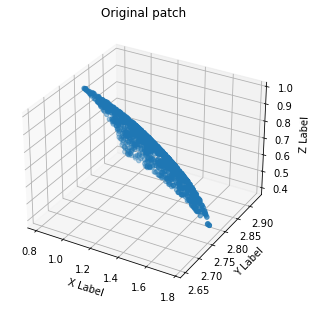

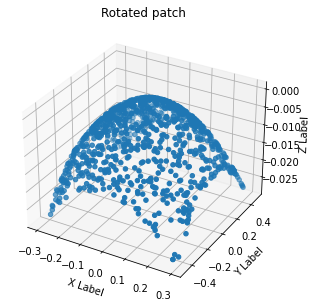

In [131]:
#  transform the data and visualize the original and transformed patches

V = rotate_data(X, y, nvec)

########################## 
#  original patch
##########################

fig1 = plt.figure(figsize=(7, 5))
ax1 = fig1.add_subplot(111, projection='3d')  
ax1.scatter(X[:, 0], X[:, 1], X[:, 2])
ax1.set_xlabel('X Label')
ax1.set_ylabel('Y Label')
ax1.set_zlabel('Z Label')
plt.title("Original patch")

# Set axes limit
#plt.xlim(-a,a)
#plt.ylim(-b,b)

##########################
# rotated patch
#########################

fig2 = plt.figure(figsize=(7, 5))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.scatter(V[:, 0], V[:, 1], V[:, 2])

ax2.set_xlabel('X Label')
ax2.set_ylabel('Y Label')
ax2.set_zlabel('Z Label')
plt.title("Rotated patch")

plt.show()


### 4.2.2. Testing (**1 pt**)

Make sure the maximum $z$-value is 0 and that this value is attained at the origin: 

In [132]:
print(np.max(V[ : , 2]))
##
idx = np.argmax(V[:, 2])
##
print(V[idx])

-4.462385973778848e-05
[-1.42909634e-02 -3.36283919e-03 -4.46238597e-05]


## 4.3 Run the multivariate weighted regression (**8 pts**)

Next we minimize the objective function
		$$
			\sum_{k=1}^m w_k |z_k - f(x_k,y_k)|^2 \to  \min \tag{1}
		$$
where $f(x,y) = ax^2 + 2bxy + cy^2 +dx + ey$ and $\mathbf{v}_k = (x_k,y_k,z_k)^\top$ (expressed in the local coordinates), and $w_k$ are the weights of the points. This is the standard quadratic regression problem; reformulate it as a least square problem and derive the solution.  

### 4.3.1. Theoretical part (**3 pts**): 
1.   Rewrite (1) in the matrix notations
$$
X = \begin{bmatrix}
    x_{1}^{2} & 2x_{1}y_{1} & y_{1}^{2} & x_{1} & y_{1} \\
    x_{2}^{2} & 2x_{2}y_{2} & y_{2}^{2} & x_{2} & y_{2} \\
    x_{3}^{2} & 2x_{3}y_{3} & y_{3}^{2} & x_{3} & y_{3} \\
    \vdots & \vdots & \vdots  & \vdots & \vdots\\
    x_{k}^{2} & 2x_{k}y_{k} & y_{k}^{2} & x_{k} & y_{k} \\
\end{bmatrix};
W = \begin{bmatrix}
    w_{1} & 0 & 0 & \dots & 0 \\
    0 & w_{2} & 0 & \dots & 0 \\
    0 & 0 & w_{3} & \dots & 0 \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    0 & 0 & 0 & \dots & w_{k} \\
\end{bmatrix};
\beta = \begin{bmatrix}
           a \\
           b \\
           c \\
           d \\
           e \\
\end{bmatrix};
\beta = \begin{bmatrix}
           z_{1} \\
           z_{2} \\
           \vdots \\
           z_{k} \\
\end{bmatrix} \\ \\

\argmin_{\beta} || W^{\frac{1}{2}}(z - X\beta) ||^{2}
$$

2.   Derive the closed form solution (the normal equation)
$ \newline \hspace{1cm} \newline $
Let $\'X = W^{\frac{1}{2}}X \\$
Let $\'z = W^{\frac{1}{2}}z \\$
$ \newline \hspace{1cm} \newline $
$ \\ RSS(\beta) = (\'z - \'X\beta)^{T}(\'z - \'X\beta) \\ $
$ \\ RSS(\beta) = \'z^{T}\'z - \'z^{T}\'X\beta - \beta^{T}\'X^{T}\'z + \beta^{T}\'X^{T}\'X\beta \\ $
$ \\ RSS(\beta) = \'z^{T}\'z - 2\beta^{T}\'X^{T}\'z + \beta^{T}\'X^{T}\'X\beta $
$ \newline \hspace{1cm} \newline $
Let differentiat with respect to $\beta$
$ \newline \hspace{1cm} \newline $
$ \\ \frac{\partial RSS}{\partial \beta} = 0 - 2\'X^{T}\'z + 2\'X^{T}\'X\beta \\$
$ \newline \hspace{1cm} \newline $
To minimize $RSS$ set derivative equal to 0
$ \newline \hspace{1cm} \newline $
$ \\ \frac{\partial RSS}{\partial \beta} = 0 \implies 0 - 2\'X^{T}\'z + 2\'X^{T}\'X\beta = 0 \implies \'X^{T}(\'z - \'X\beta) = 0 \\ $
$ \newline \hspace{1cm} \newline $
Under ussumption that $\'X$ is full column rank which means $\'X^{T}\'X$ is positive definite and invertible
$ \newline \hspace{1cm} \newline $
$ \\ \'X^{T}\'z = \'X^{T}\'X\beta \implies (\'X^{T}\'X)^{-1}\'X^{T}\'z = \hat \beta \\ $

### 4.3.2. Coding part (**1 pt**)

In [143]:
# weighted multilinear regression
def quadr_regr(V, c):
  """
  V is the transformed surface patch
  c is the hyperarameter in the weights
  """
  wghts = weights(V, [0,0,0], c)
  V_len  = len(V)
  ##
  A = np.vstack([ 
    V[:, 0]**2,           # a * x^2
    V[:, 0]*V[:, 1]*2,    # b * 2xy
    V[:, 1]**2,           # c * y^2
    V[:, 0],              # d * x
    V[:, 1]               # e * y
  ])
  ##
  B = np.multiply(wghts, A)
  b = wghts * V[:,2]
  
  return np.linalg.lstsq(B.T, b, rcond=None)[0]

In [144]:
w = quadr_regr(V, 1000)
print(w)

[-0.17017066 -0.0041125  -0.0641751   0.00020578  0.0017304 ]


### 4.3.3. **Questions (4 pts)**

1.   Why are w[0] and w[2] expected to be negative?
2.   Why are w[3] and w[4] expected to be small?

...  
... 


## 4.4. Finding the curvatures and principal directions (**1 pt**)

Take the quadratic part of the function $f(x,y)$, form the correponsing matrix $A$, and calculate its eigenvalues and eigenvectors

In [145]:
eval, evec = np.linalg.eigh([[w[0], w[1]], [w[1], w[2]]])

print("Estimated curvatures: ", 2*eval)
print("Actual curvatures: ", curvatures(y))


Estimated curvatures:  [-0.34065996 -0.12803155]
Actual curvatures:  (0.12812009583171055, 0.3406884535187834)


***Question:*** Observe that the estimated curvatures are negative; this is due to the orientation of the surface. Take their absolute values and compare to the actual ones

...  

They are very similar to each other, though sorted differently

...

### 4.4.2. Principal directions (**1 pt**)

Augment the eigenvectors with $z = 0$ and find the estimated principal directions at the point $\mathbf{y}_0$ (apply the inverse rotation)

In [141]:
dir_v1 = np.append(evec[0], 0)

dir_vec1 = np.dot(np.linalg.inv(Urotate), dir_v1).T

dir_v2 = np.append(evec[1], 0)

dir_vec2 = np.dot(np.linalg.inv(Urotate), dir_v2).T

print("Evaluated principal directions", dir_vec1, dir_vec2)
print("Actual principal directions:", directions(y))


Evaluated principal directions [-0.07630967 -0.22690053  0.97092378] [ 0.98468957 -0.17021051  0.03761416]
Actual principal directions: (array([-0.98737156,  0.15380543,  0.03796432]), array([ 0.        , -0.23964109,  0.97086155]))


## 4.5. Testing (**4 pts**)

Test the above procedure for $n=100$ random points and evaluate the efficiency of the curvature estimation. Think of an appropriate metric and explain your choice

...  
...


In [159]:
## your code here

ED = []
for _ in range(100):
    phi_, psi_ = np.pi * np.random.rand(2)

    y_ = surface_point([phi_,psi_])
    X_ = surface_patch(phi_, psi_, no_pts = 1000, size = 0.1)

    nvec_ = normal_pla(X_, y_, False)

    V_ = rotate_data(X_, y_, nvec_)
    w_ = quadr_regr(V_, 1000)
    eval_, _ = np.linalg.eigh([[w_[0], w_[1]], [w_[1], w_[2]]])
    real = np.array(sorted(abs(eval_*2)))
    expected = np.array(sorted(curvatures(y_)))
    ED += [np.linalg.norm(real-expected)]
ED=np.array(ED)
print("min: ", np.amin(ED))
print("max: ", np.amax(ED))
print("mean: ", np.mean(ED))
print("median: ", np.median(ED))
print("std: ", np.std(ED))
print("var: ", np.var(ED))

min:  5.919163413867607e-06
max:  0.0005798974900927917




In this practical part, your task will be to 


1.   For a given point $P = \mathbf{y}_0$ of the ellipsis, move the origin to $P$
2.   Rotate the coordinates to align the $z$-axis and the normal $\mathbf{n}$ to $E$ at the point $P$
3.   Use the multivariable weighted linear regression to fit the patch of $E$ around the point $P$ to the equation
$$
  z = a_{11}x^2 + 2a_{12}xy + a_{22}y^2 + a_1 x + b_1 y
$$
4.   Find the eigenvalues and eigenvectors of the symmetric matrix $A$ of the above quadratic form and form the principal curvatures of $E$ at the point $P$
5.   Compare the curvatures $\kappa_1$ and $\kappa_2$ and principal directions $\mathbf{d}_1$ and $\mathbf{d}_2$ to the explicit theoretical values
6.   Repeat the above steps for $N=100$ randomly selected points on $E$ and comment on the precision of the method




## 5. Summary **(4 pts)**

Write a short report about the work you did.

Do not forget to discuss the following points:

*   what approaches to estimate normals you tried;
    1) Naive approach that directly estimated minimized $\sum_{k=1}^{m} n(x_i-x_0)$, resulted in just -normalized average of translated points from surface patch. 
    2) Weighted naive approach, where weights are exponentially smaller for points that are further from $y_0$. Looks to me like works even worse then the previous one.
    3) Estimate tangent plane to the surface near generated patch. Resulted in the similar, loss function to minimize: $f(\mathbf{n}) = \sum_{k=1}^{m} w_k |\mathbf{n} \cdot (\mathbf{y}_k-\mathbf{y}_0)|$
    4) PLA aproach - At each iteration we move our normal so that all points are on the one side from plane those normal is our surface patch normal at $y_0$.

*   which of them worked and which failed, and why
    Naive worked, but quite bad, and required a whole lot of points to start approaching actual normal. Looks like is not very stable, since from generation to generaion for the same patch size works better or quite worse. 
   

    The weighted worked even worse, unless I make `c` very small, so that is becomes practically naive. Not sure why, but I think that since weights are exponential, this is quite similar to just removal of points. But as we saw, naive worked very bad unless there are a lot of generated points.

    Tangent plance estimation and PLA both worked very well. Both work no directly with points, but rather through tangent place estimated by points. Looks like plane estimation is much less sensitive to point generation, so it gives much better estimate of normal. 


*   a general idea behind estimating principal curvatures
    
    The main idea - translate and rotate our points so that $y_0 \rightarrow [0, 0, 1]$. After that it is quite easy to fit patch of points to paraboloid. After we fitted points, as it turnes out, eigen values of quadratic form equal to 1/2 * principal curvatures. So using some linear algebra, after fit we can determine principal curvatures. Also eigenvectors are a principal directions, so by using inverse transformation from normal parametrization, we can derive principal directions.  

*   any difficulties you had completing the tasks.
    - I derived closed solution for naive normal estimation in a very stupid way and overcomplicated if for some reason. In a vector form, solution is trivial. Other parts of normal esimation were quite understandable. 



## 6. Comments and suggestions to improve this lab assignment (optional, up to 4 extra points)

